In [92]:
import csv
import sklearn
import openpyxl

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import umap.umap_ as umap
from scipy.linalg import eigh as largest_eigh
from scipy.linalg import orthogonal_procrustes

In [46]:
bin_df = pd.read_csv("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/gap.blacklist.hg38.1000000.4col.autosomal.bed", sep='\t', names=["chr","start","end","name"])
delete_bins = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/delete_bins.npy")
bin_df_new = bin_df.drop(delete_bins).reset_index(drop=True)

In [90]:
Disease = "MDD"

Ast MDD


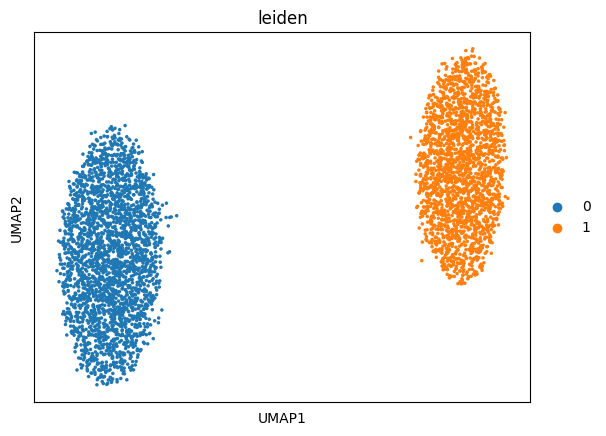

15952.357826253348 11513.635207823962
Ast PTSD


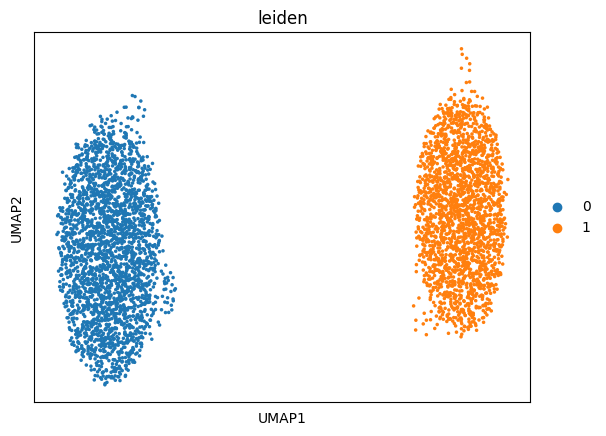

17576.766188445134 12540.128908128909
End MDD


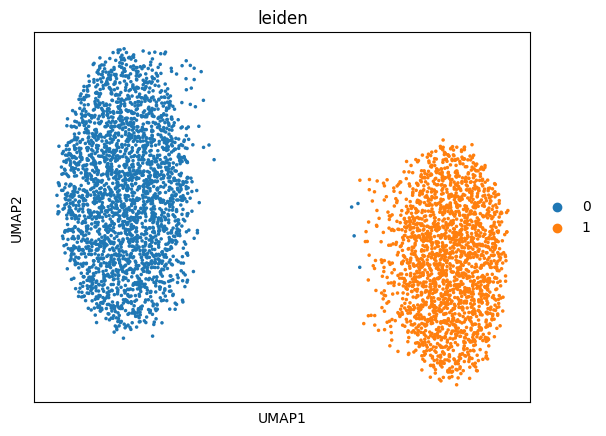

1806.948679245283 2653.6240039840636
End PTSD


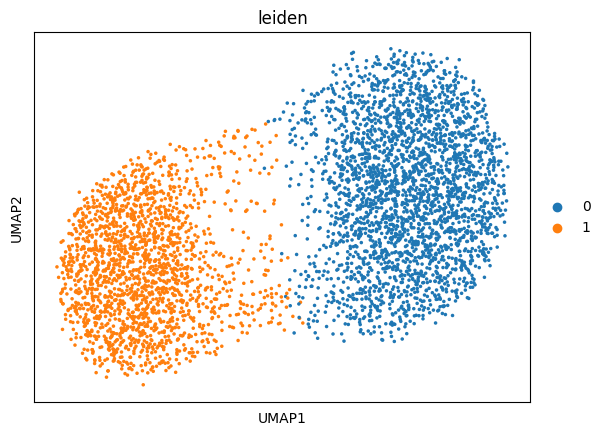

1750.5180115273774 2808.0541976620616
Exc MDD


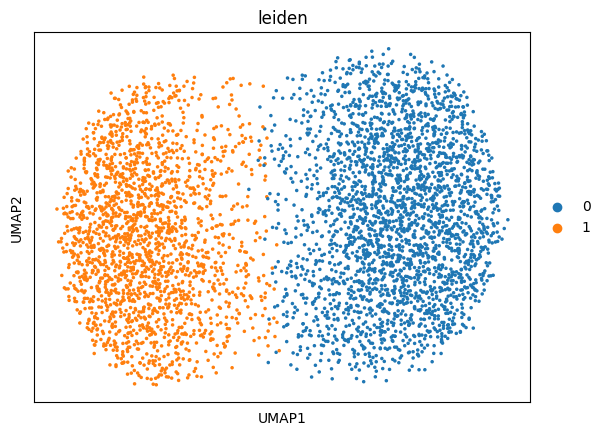

65862.25757575757 105434.23975409837
Exc PTSD


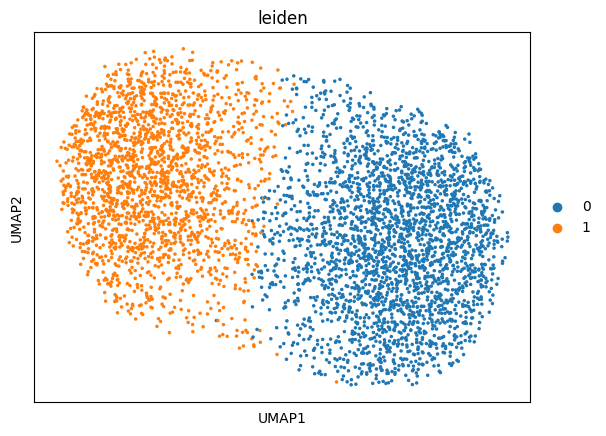

70139.23804185352 109313.87891019172
Inh MDD


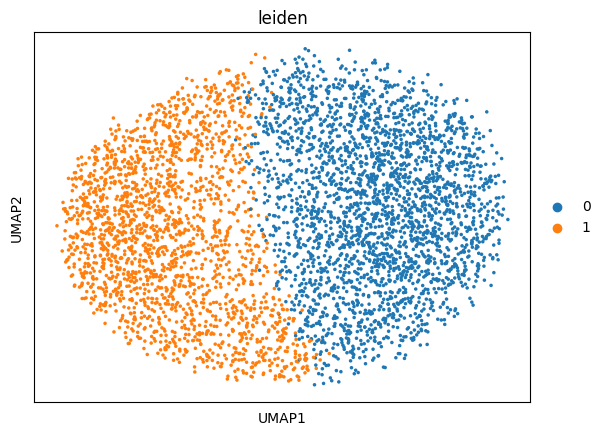

16408.522143654634 23560.73769660071
Inh PTSD


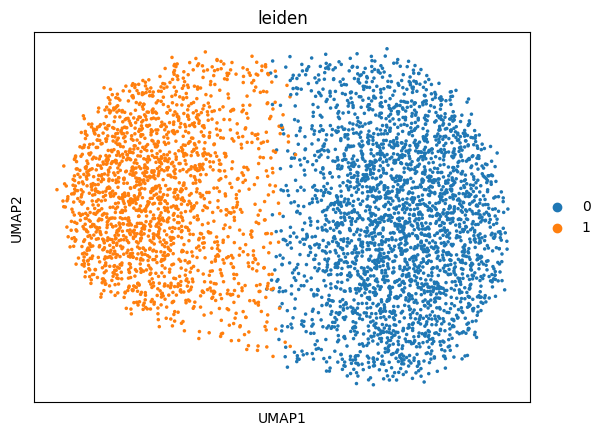

18286.95914742451 26679.14378730331
Mic MDD


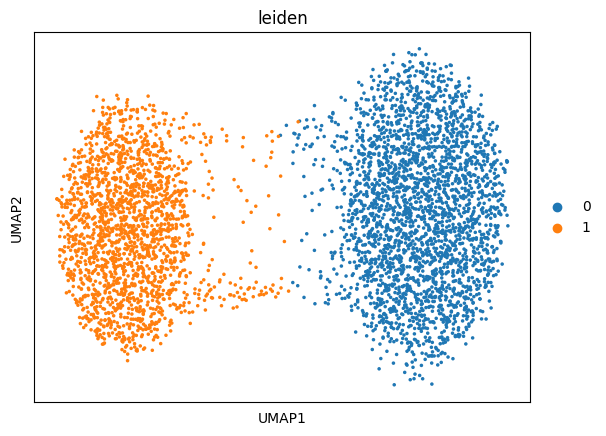

5126.924391130498 10058.267960146828
Mic PTSD


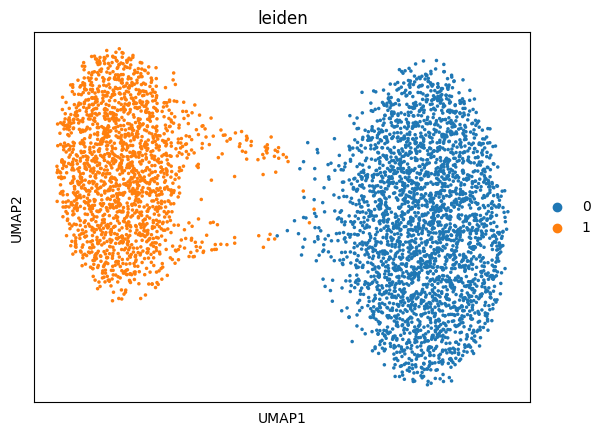

5599.55987394958 11835.859600443951
Olig MDD


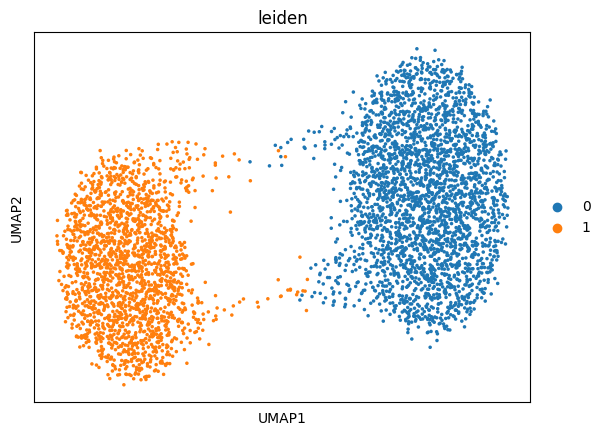

18214.025399129172 41803.09726603575
Olig PTSD


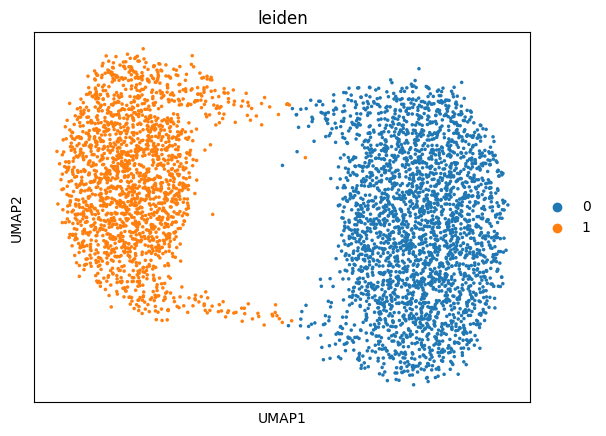

17085.307001795332 36719.70475173518
OPC MDD


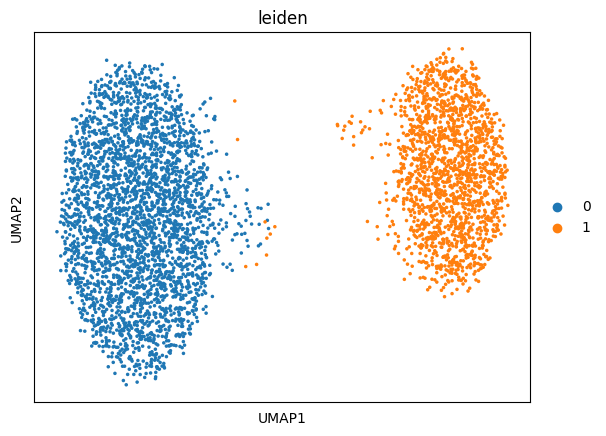

4951.722129783694 8747.966122202057
OPC PTSD


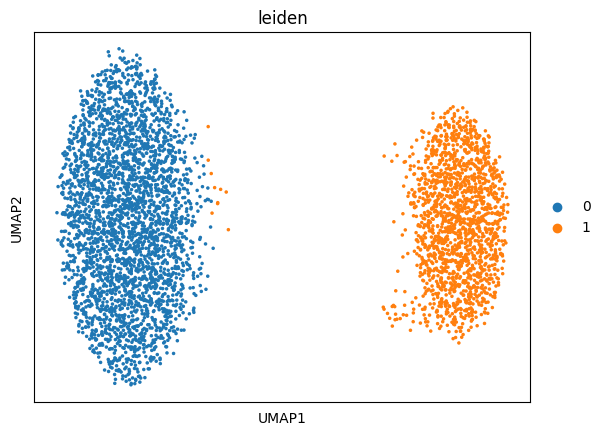

5408.9578706727625 9992.892857142857


In [94]:
metacell = 200
embedding_size = 32

# for cell_type in ["Exc"]:
for cell_type in ["Ast", "End", "Exc", "Inh", "Mic", "Olig", "OPC"]:
    for Disease in ["MDD", "PTSD"]:
    
        print(cell_type, Disease)

        CON_emb = np.load("/auto/grad_space/zihend1/scENCORE/Change_Resolution/1000K/3_CON/cell_type/"+cell_type+"/"+str(metacell)+"_metacell/Embedding/corr_0_1_VERSE_"+str(embedding_size)+".npy")
        CON_feature = np.load("/auto/grad_space/zihend1/scENCORE/Change_Resolution/1000K/3_CON/cell_type/"+cell_type+"/raw/feature.npy")
        
        if Disease == "MDD":
            Disease_emb = np.load("/auto/grad_space/zihend1/scENCORE/Change_Resolution/1000K/2_MDD/cell_type/"+cell_type+"/"+str(metacell)+"_metacell/Embedding/corr_0_1_VERSE_"+str(embedding_size)+".npy")
            Disease_feature = np.load("/auto/grad_space/zihend1/scENCORE/Change_Resolution/1000K/2_MDD/cell_type/"+cell_type+"/raw/feature.npy")
        elif Disease == "PTSD":
            Disease_emb = np.load("/auto/grad_space/zihend1/scENCORE/Change_Resolution/1000K/2_PTSD/cell_type/"+cell_type+"/"+str(metacell)+"_metacell/Embedding/corr_0_1_VERSE_32.npy")
            Disease_feature = np.load("/auto/grad_space/zihend1/scENCORE/Change_Resolution/1000K/2_PTSD/cell_type/"+cell_type+"/raw/feature.npy")

        R, _ = orthogonal_procrustes(Disease_emb, CON_emb)
        transfer_Disease_emb = Disease_emb @ R

        CON_emb = (CON_emb-np.min(CON_emb))/(np.max(CON_emb)-np.min(CON_emb))
        transfer_Disease_emb = (transfer_Disease_emb-np.min(transfer_Disease_emb))/(np.max(transfer_Disease_emb)-np.min(transfer_Disease_emb))
        D = np.sqrt((np.sum((transfer_Disease_emb[:,:] - CON_emb[:,:])**2, axis=1)))
        CSS = 1-np.exp(-D)

        embedding = np.vstack((CON_emb, transfer_Disease_emb))
        adata = ad.AnnData(embedding)
        sc.pp.neighbors(adata, n_neighbors=100, use_rep='X')
        sc.tl.leiden(adata,resolution=0.5)
        sc.tl.umap(adata)
        fig = sc.pl.umap(adata, color='leiden', return_fig=True)
        plt.show()

        pos = np.array(adata.obsm['X_umap'])
        color_array = np.array(adata.obs["leiden"], dtype=np.int32)
        total_feature = np.hstack((np.sum(CON_feature, axis=0), np.sum(Disease_feature, axis=0)))

        print(np.mean(total_feature[np.where(color_array==0)]),np.mean(total_feature[np.where(color_array==1)]))
        a_class = np.where(color_array==1)[0]
        b_class = np.where(color_array==0)[0]
        # switching
        CON_a_class = a_class[np.where(a_class<2329)[0]]
        Disease_a_class = a_class[np.where(a_class>=2329)[0]]-2329
        CON_b_class = b_class[np.where(b_class<2329)[0]]
        Disease_b_class = b_class[np.where(b_class>=2329)[0]]-2329
        # a2b
        CON_a_2_Disease_b = np.array(list(set(CON_a_class) - set(Disease_a_class)))
        CON_a_2_Disease_b_pd = bin_df_new.loc[CON_a_2_Disease_b[np.argsort(-CSS[CON_a_2_Disease_b])],:]
        CON_a_2_Disease_b_pd['CSS'] = CSS[CON_a_2_Disease_b[np.argsort(-CSS[CON_a_2_Disease_b])]]
        CON_a_2_Disease_b_pd.to_excel("./table/CON_a_2_"+Disease+"_b_"+cell_type+"_.xlsx")
        # b2a
        CON_b_2_Disease_a = np.array(list(set(CON_b_class) - set(Disease_b_class)))
        CON_b_2_Disease_a_pd = bin_df_new.loc[CON_b_2_Disease_a[np.argsort(-CSS[CON_b_2_Disease_a])],:]
        CON_b_2_Disease_a_pd['CSS'] = CSS[CON_b_2_Disease_a[np.argsort(-CSS[CON_b_2_Disease_a])]]
        CON_b_2_Disease_a_pd.to_excel("./table/CON_b_2_"+Disease+"_a_"+cell_type+"_.xlsx")